# Comparing Representations

### Setup

In [1]:
import os
import time
import json

import numpy as np
import pandas as pd

import urlextract
from datetime import datetime
from nltk.stem import WordNetLemmatizer

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-06


### Load Data

In [2]:
def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### 1. New Features

In [3]:
%%capture output

# custom feature engineering module
import feature_engineering as Fe

try:                   
    clean_train_docs, X_train_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass

# impute with zeros
X_train_feat[np.isnan(X_train_feat)] = 0

### 2. BoW

More precisely, a bag-of-upto-bigrams with a vocabulary size of 2,000 terms.

In [4]:
import cleanup_module as Cmod
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

dtm_pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=2)),
                     ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=2000))
                    ])

X_train_bow = dtm_pipe.fit_transform(X_train)

### 3. BoW + Features

In [5]:
import scipy.sparse as sp

X_train_bow_feat = sp.hstack((X_train_feat, X_train_bow))

### 4. BoW + Doc Length

In [6]:
X_train_bow_doclen = sp.hstack((X_train_feat[:, 0:1], X_train_bow))

### 5. SVD on BoW

In [7]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MinMaxScaler

def perform_SVD(X, n_topics=300):
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, k=n_topics)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    # return V (for now)
    V = VT.T
    return V

X_train_svd = perform_SVD(X_train_bow)

# scale for precision/recall calcs
scaler = MinMaxScaler()
X_train_svd_scaled = scaler.fit_transform(X_train_svd)

# make sparse for stacking
X_train_svd_scaled = sp.csr_matrix(X_train_svd_scaled)

### 6. SVD-on-BoW + Features

In [8]:
X_train_svd_feat = sp.hstack((X_train_svd_scaled, X_train_feat))

### 7. SVD-on-BoW + DocLen

In [9]:
X_train_svd_doclen = sp.hstack((X_train_svd_scaled, X_train_bow_doclen))

## Logistic Regression

A quick modeling phase with a baseline classifier to compare our 5 candidate representations:

1. **X_train_feat:** new features
2. **X_train_bow:** bag-of-(upto)-bigrams 
3. **X_train_bow_feat:** bow + (all) features
4. **X_train_bow_doclen:** bow + document lengths (first and best feature)
5. **X_train_svd_scaled:** svd (min max scaled) on the bow
6. **X_train_svd_feat:** svd on the bow + all features
7. **X_train_svd_doclen:** svd on the bow + document lengths

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def get_modeling_stats(Xs, Xnames, y, cv=10):

    accs_, pres_, recs_ = [], [], []
    
    for X in Xs:
        log_clf = LogisticRegression(solver="liblinear", random_state=42)
        accs = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='accuracy')
        pres = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='precision')
        recs = cross_val_score(log_clf, X, y, cv=cv, verbose=0, scoring='recall')
        accs_.append(np.round(accs, 4))
        pres_.append(np.round(pres, 4))
        recs_.append(np.round(recs, 4))
    
    data = {'representations':Xnames,
            'accuracies':accs_,
            'precisions':pres_,
            'recalls':recs_}
    
    return pd.DataFrame(data)

In [13]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

In [14]:
Xs = [
      X_train_feat, 
      X_train_bow, 
      X_train_bow_feat, 
      X_train_bow_doclen,
      X_train_svd_scaled,
      X_train_svd_feat,
      X_train_svd_doclen
     ]

Xnames = [
          'X_train_feat',       # 1. new feat
          'X_train_bow',        # 2. bigrams
          'X_train_bow_feat',   # 3. bigrams + new feats
          'X_train_bow_doclen', # 4. bigrams + doc lens
          'X_train_svd_scaled', # 5. svd
          'X_train_svd_feat',   # 6. svd + new feats
          'X_train_svd_doclen'  # 7. svd + doc lens
         ]

df = get_modeling_stats(Xs, Xnames, y_train)

In [15]:
df

,representations,accuracies,precisions,recalls
0,X_train_feat,"[0.8974, 0.8795, 0.8769, 0.8769, 0.8897, 0.866...","[0.6667, 0.5625, 0.5714, 0.5714, 0.6452, 0.5, ...","[0.4314, 0.3529, 0.2353, 0.3077, 0.3846, 0.307..."
1,X_train_bow,"[0.9769, 0.9872, 0.9744, 0.9897, 0.9872, 0.979...","[0.9375, 0.9792, 1.0, 1.0, 0.9796, 0.9783, 1.0...","[0.8824, 0.9216, 0.8039, 0.9231, 0.9231, 0.865..."
2,X_train_bow_feat,"[0.9795, 0.9795, 0.9718, 0.9872, 0.9872, 0.979...","[0.9574, 0.9388, 1.0, 1.0, 0.9796, 0.9583, 1.0...","[0.8824, 0.902, 0.7843, 0.9038, 0.9231, 0.8846..."
3,X_train_bow_doclen,"[0.9769, 0.9795, 0.9718, 0.9872, 0.9872, 0.982...","[0.9565, 0.9388, 1.0, 0.9796, 0.9796, 0.9787, ...","[0.8627, 0.902, 0.7843, 0.9231, 0.9231, 0.8846..."
4,X_train_svd_scaled,"[0.959, 0.9718, 0.9564, 0.9641, 0.9641, 0.9718...","[0.9487, 0.9762, 1.0, 1.0, 0.975, 1.0, 1.0, 0....","[0.7255, 0.8039, 0.6667, 0.7308, 0.75, 0.7885,..."
5,X_train_svd_feat,"[0.9641, 0.9718, 0.959, 0.9718, 0.9744, 0.9538...","[0.8936, 0.9167, 0.973, 0.9767, 0.9565, 0.8696...","[0.8235, 0.8627, 0.7059, 0.8077, 0.8462, 0.769..."
6,X_train_svd_doclen,"[0.9769, 0.9795, 0.9718, 0.9846, 0.9872, 0.976...","[0.9565, 0.9388, 1.0, 0.9792, 0.9796, 0.9388, ...","[0.8627, 0.902, 0.7843, 0.9038, 0.9231, 0.8846..."


In [16]:
# calc means for plotting
mean_accs  = [round(np.mean(x),4) for x in df.loc[:,"accuracies"]]
mean_precs = [round(np.mean(x),4) for x in df.loc[:,"precisions"]]
mean_recs  =  [round(np.mean(x),4) for x in df.loc[:,"recalls"]]

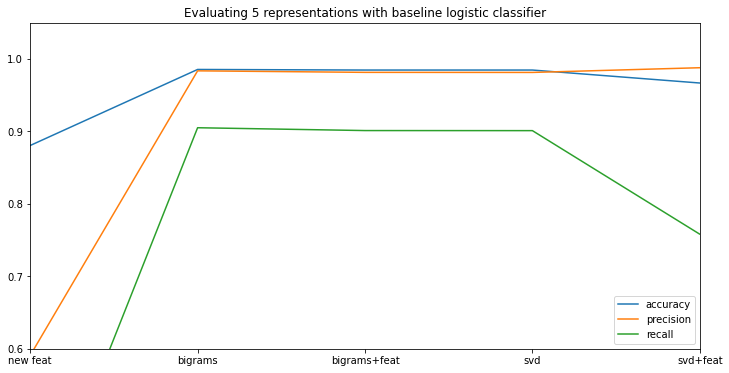

In [17]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6)) 
plt.plot(mean_accs, label="accuracy")
plt.plot(mean_precs, label="precision")
plt.plot(mean_recs, label="recall")
plt.title('Evaluating 5 representations with baseline logistic classifier')
plt.xticks(np.arange(5), ('new feat', 'bigrams', 'bigrams+feat', 'svd', 'svd+feat'))
plt.legend(loc="lower right")
plt.axis([0, 4, 0.6, 1.05])
plt.show()

As expected, the new features alone aren't too useful. The bag-of-bigrams perform about the same with the new features added; it is the svd that improves recall and possibly accuracy with the new features a bit. This might be a greater benefit with a more complex model like random forests. Precision-recall curves confirm this.


### Precision-Recall Curves

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_PR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    log_clf.fit(X_train, y_train)
    p = plot_precision_recall_curve(log_clf, X_test, y_test)

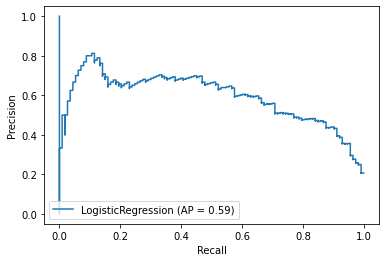

In [19]:
plot_PR(X_train_feat, y_train)

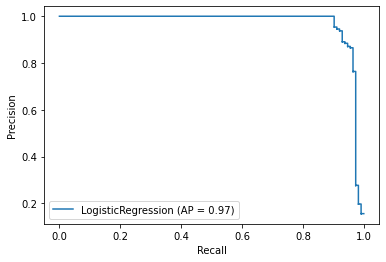

In [20]:
plot_PR(X_train_bow, y_train)

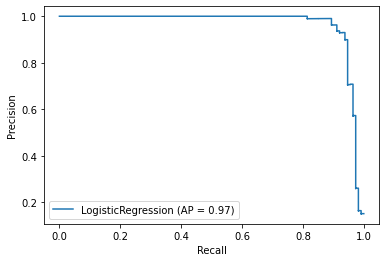

In [21]:
plot_PR(X_train_bow_feat, y_train)

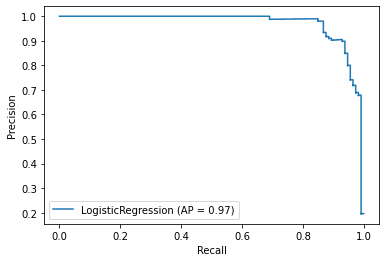

In [22]:
plot_PR(X_train_svd_scaled, y_train)

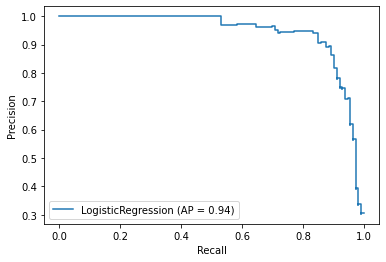

In [23]:
plot_PR(X_train_svd_feat, y_train)

In [24]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 2 m 16 s


---